# Example Script to Load, Plot, and Fit Energy Spectra

## Import needed libs:

In [2]:
import numpy as np

import matplotlib as mpl
#mpl.rcParams['mathtext.fontset'] = 'cm'
#mpl.rc('font', family='serif')

import matplotlib.pyplot as plt
import matplotlib.image as img 
from matplotlib import ticker, cm

import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

import sys, code, os
import math
import random

from scipy import stats
from scipy import interpolate 
from scipy.optimize import curve_fit

from array import array

import pickle

## Point to the data dir:

In [1]:
mypath = "/Users/shaoleili/Downloads/APD_data"

## Read out energy arrays from pickle files:

In [10]:
with open(mypath+'/label_energy_Co_0_10001.pkl','rb') as file:
    labels = pickle.load(file,encoding='bytes')
file.close()

with open(mypath+'/real_recon_energy_Co_0_10001.pkl','rb') as file:
    reals = pickle.load(file,encoding='bytes')
file.close()

with open(mypath+'/generated_recon_energy_Co_0_10001.pkl','rb') as file:
    gens = pickle.load(file,encoding='bytes')
file.close()

## Useful functions we will need:

In [4]:
#get chi-square and number of degrees of freedom
def my_chisq(func,popt,x,data,data_err,cutoff_l=0,cutoff_h=np.inf,pearson=False):
    chi=0
    ndf = -1.*len(popt)
    
    for i in range(0,len(data)):
        if x[i]<cutoff_l or x[i]>cutoff_h:
            continue
        diff = (func(x,*popt)[i]-data[i])**2
        err = func(x,*popt)[i] if pearson==True else data_err[i]**2
        chi = chi + diff/err
        #print diff, err, chi
        ndf = ndf + 1
    return chi, ndf

In [5]:
#make error bars and bin-centered points
def get_errs(n):
    err_list = []
    for i in range(0,len(n)):
        if n[i]!=0:
            err_i = np.sqrt(n[i])
        else:
            err_i = 1.
        err_list.append(err_i)
    return np.asarray(err_list)

def get_centers(bins,step):
    centers_list = []
    n = len(bins)-1
    for i in range(0,n):
        e_i = bins[i]+step/2.
        centers_list.append(e_i)
    return np.asarray(centers_list)

In [6]:
#fit function
def g_lin_fit(x,a,m,s,p0):
        #super inefficent way to use python:
        y = []
        for x_i in x:
            y_i= a/s/np.sqrt(2*np.pi)*np.exp(-(x_i-m)*(x_i-m)/2/s/s) + math.erf((m - x_i)/s)*p0 + p0
            y.append(y_i)
        return y

In [7]:
#get subset of array within the fit range
def get_range(cents,n,err,left,right):
    centv         = np.vstack((cents,n)).T
    cent_err      = np.vstack((cent,err)).T
    cent_range    = centv[((centv[:,0]>left)&(centv[:,0]<right)),0]
    n_range       = centv[((centv[:,0]>left)&(centv[:,0]<right)),1]
    err_range     = cent_err[((cent_err[:,0]>left)&(cent_err[:,0]<right)),1]
    return cent_range, n_range, err_range

## Histogram the arrays, Fit the 2.6 MeV peak with Gaus+Erf

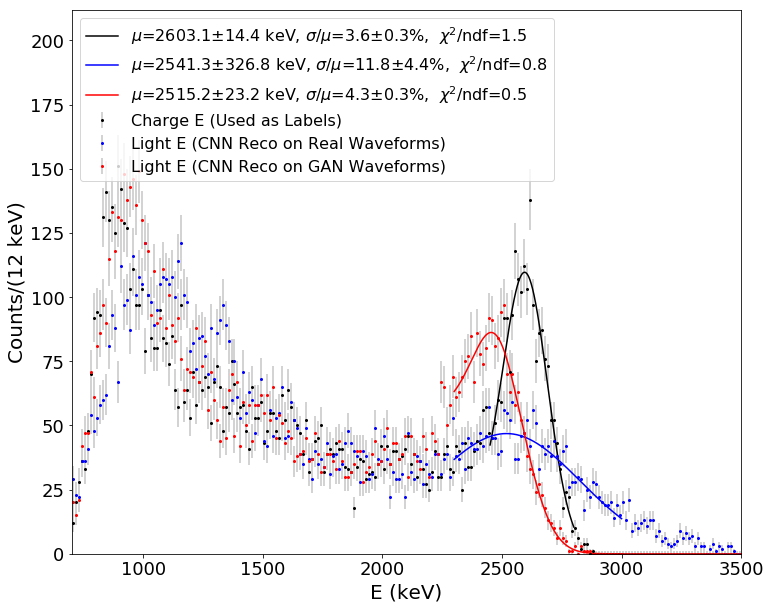

In [13]:
#set the figure size
plt.rcParams['figure.figsize'] = [12, 10]

#create binning
left = 700.
right = 3500
nbins = 224
mybins = np.linspace(left,right,nbins+1)
e_step = (right-left)/nbins

#get bin content
nlabels, bins = np.histogram(labels,bins=mybins)
nreals, bins  = np.histogram(reals, bins=mybins)
ngens, bins   = np.histogram(gens,  bins=mybins)

err_l = get_errs(nlabels)
err_r = get_errs(nreals)
err_g = get_errs(ngens)
cent  = get_centers(mybins,e_step)

#now actually plot
#plt.step(cent,nlabels,'k',where='mid',linewidth=2) #try adding this for coarse binning - may look nicer
plt.errorbar(cent,nlabels,yerr=err_l,ecolor='lightgrey',capsize=0,elinewidth=2,fmt='o',color='k',markersize=2.,label=r'Charge E (Used as Labels)')
plt.errorbar(cent,nreals,yerr=err_r,ecolor='lightgrey',capsize=0,elinewidth=2,fmt='o',color='b',markersize=2.,label=r'Light E (CNN Reco on Real Waveforms)')
plt.errorbar(cent,ngens,yerr=err_g,ecolor='lightgrey',capsize=0,elinewidth=2,fmt='o',color='r',markersize=2.,label=r'Light E (CNN Reco on GAN Waveforms)')

#Accuracy of axis labels tells people if you are a professional or a hack!
plt.xlabel(r'E (keV)',fontsize=20)
plt.ylabel(r'Counts/(%.0f keV)'%(e_step),fontsize=20)

#Set axes limits
plt.axis((left,right,0,np.max(nreals)*1.75))

#fit range
left_l  = 2450.
right_l = 2800.
left_r  = 2300.
right_r = 3000.
cent_range_l, nrange_l, err_range_l = get_range(cent,nlabels,err_l,left_l,right_l)
cent_range_r, nrange_r, err_range_r = get_range(cent,nreals,err_r,left_r,right_r)
cent_range_g, nrange_g, err_range_g = get_range(cent,ngens,err_g,left_r,right_r)
xl = np.linspace(left_l,right_l,500)
xr = np.linspace(left_r,right_r,500)
xg = np.linspace(left_r,right_r,500)


#initial parameter guess and bounds
first = (4000,2614.5,50,100)
bound=([0,2400,20,0],[np.inf,2700,300,5000])

#now fit and plot results
popt_l, pcov = curve_fit(g_lin_fit, cent_range_l, nrange_l,first, maxfev=10000,sigma=err_range_l,absolute_sigma=True,bounds=bound)
perr_l = np.sqrt(np.diag(pcov))
mychi2,ndof = my_chisq(g_lin_fit,popt_l,cent_range_l,nrange_l,err_range_l)
plt.plot(xl, g_lin_fit(xl, *popt_l), 'k-',label=r'$\mu$=%5.1f$\pm$%3.1f keV, $\sigma$/$\mu$=%1.1f$\pm$%1.1f%%,  $\chi$$^2$/ndf=%.1f' % (popt_l[1],perr_l[1],popt_l[2]/popt_l[1]*100.,perr_l[2]/popt_l[1]*100.,mychi2/ndof) )

popt_r, pcov = curve_fit(g_lin_fit, cent_range_r, nrange_r,first, maxfev=10000,sigma=err_range_r,absolute_sigma=True,bounds=bound)
perr_r = np.sqrt(np.diag(pcov))
mychi2,ndof = my_chisq(g_lin_fit,popt_r,cent_range_r,nrange_r,err_range_r)
plt.plot(xr, g_lin_fit(xr, *popt_r), 'b-',label=r'$\mu$=%5.1f$\pm$%3.1f keV, $\sigma$/$\mu$=%1.1f$\pm$%1.1f%%,  $\chi$$^2$/ndf=%.1f' % (popt_r[1],perr_r[1],popt_r[2]/popt_r[1]*100.,perr_r[2]/popt_r[1]*100.,mychi2/ndof) )

popt_g, pcov = curve_fit(g_lin_fit, cent_range_g, nrange_g,first, maxfev=10000,sigma=err_range_g,absolute_sigma=True,bounds=bound)
perr_g = np.sqrt(np.diag(pcov))
mychi2,ndof = my_chisq(g_lin_fit,popt_g,cent_range_g,nrange_g,err_range_g)
plt.plot(xg, g_lin_fit(xg, *popt_g), 'r-',label=r'$\mu$=%5.1f$\pm$%3.1f keV, $\sigma$/$\mu$=%1.1f$\pm$%1.1f%%,  $\chi$$^2$/ndf=%.1f' % (popt_g[1],perr_g[1],popt_g[2]/popt_g[1]*100.,perr_g[2]/popt_g[1]*100.,mychi2/ndof) )


plt.legend(loc='upper left',numpoints = 1,frameon=True,prop={'size': 16})
plt.gca().tick_params(labelsize=18)

plt.savefig(mypath+'/reco_fit_check_Co.png',bbox_inches = 'tight')